In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("src/")
import operator
from importlib import reload
import src.preprocessing.data_loading as data_loading
import models.experiment as experiment
import models.rnn as rnn
import analysis.umap_analysis as umap
import analysis.scatter_plots as scatter_plots
import analysis.evaluation as evaluation
from preprocessing.X_representation import RAA_to_seq
from preprocessing.X_representation_utils import initialize_Proc2Vec_embeddings
from utils.utils import find_3mer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from analysis.heatmap_analysis import generate_heatmap
from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
)
import itertools
from functools import partial
import pdb

from analysis.hit_rate_analysis import (
    plot_ratio_by_ranking,
    sort_peptides_by_model_ranking,
    seq_contains_mdm2_motif,
)

2023-03-21 10:24:00.859821: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 10:24:01.005843: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-21 10:24:01.541764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.0/lib64:/usr/local/cuda-11.0/lib64
2023-03-21 10:24:01.541842: W ten

In [10]:
protein_of_interest = "MDM2"
other_protein = "12ca5"

X, y_raw, peptides = data_loading.build_joint_dataset(
    er_datafile =f"{protein_of_interest}_merged_ER.csv",
    volcano_datafile="12ca5-MDM2-mCDH2-R3.csv",
    protein_of_interest=protein_of_interest, 
    other_protein=other_protein
)

/home/yitongt/ml_phage/src/preprocessing/y_representation.py:66: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  lib["pvalues"] = sp.stats.ttest_ind(


# What sort of fancy plots do we have?

In [5]:
import seaborn as sns
import plotly.graph_objects as go
from mpl_toolkits.mplot3d import Axes3D


def plot_relations_in_plotly(x_idx, y_idx, datapoints, vals=["Pval", "FC", "ER"]):
    fig = go.Figure(
        [
            go.Scatter(
                x=datapoints[:, x_idx],
                y=datapoints[:, y_idx],
                text=peptides,
                mode="markers",
            )
        ]
    )
    fig.show()


def plot_relations(
    x_idx, y_idx, datapoints, ordering, kind="hex", vals=["Pval", "FC", "ER"], top_k=500
):
    sns.jointplot(x=datapoints[:, x_idx], y=datapoints[:, y_idx], kind=kind)
    plt.xlabel(vals[x_idx])
    plt.ylabel(vals[y_idx])
    plt.title(vals[x_idx] + ' vs ' + vals[y_idx])

    if ordering is not None:
        top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
        plt.scatter(
            x=datapoints[:, x_idx][top_k_mask],
            y=datapoints[:, y_idx][top_k_mask],
            color="red",
            alpha=0.01,
        )
    plt.show()


def plot_relations_in_3D(
    x_idx,
    y_idx,
    uncertainty,
    datapoints,
    ordering,
    title="",
    vals=["Pval", "FC", "ER"],
    top_k=500,
):
    sns.set_style("whitegrid", {"axes.grid": False})
    fig = plt.figure(figsize=(6, 6))

    ax = Axes3D(fig)
    if ordering is not None:
        top_k_mask = ordering >= np.partition(ordering, kth=-top_k)[-top_k]
        color = [(1, 0, 0, 1) if c else (0.8, 0.8, 0.8, 0.1) for c in top_k_mask]
    else:
        color = uncertainty

    ax.scatter(
        xs=datapoints[:, x_idx],
        ys=datapoints[:, y_idx],
        zs=uncertainty,
        c=color,
        marker="o",
    )
    ax.set_xlabel("Pred " + vals[x_idx])
    ax.set_ylabel("Pred " + vals[y_idx])
    ax.set_zlabel("Uncertainty")

    plt.title(title)
    ax.view_init(elev=10.0, azim=90)
    plt.show()


In [11]:
y_raw

array([[14.67938063, -9.07577907,  1.76921603],
       [13.59892939, -9.18565747, -0.3530744 ],
       [15.77429541, -9.41616917, -2.24615919],
       ...,
       [ 0.98376431,  3.09104245, -0.5940825 ],
       [ 0.98376431,  3.09104245, -0.5940825 ],
       [ 0.98376431,  3.09104245, -0.5940825 ]])

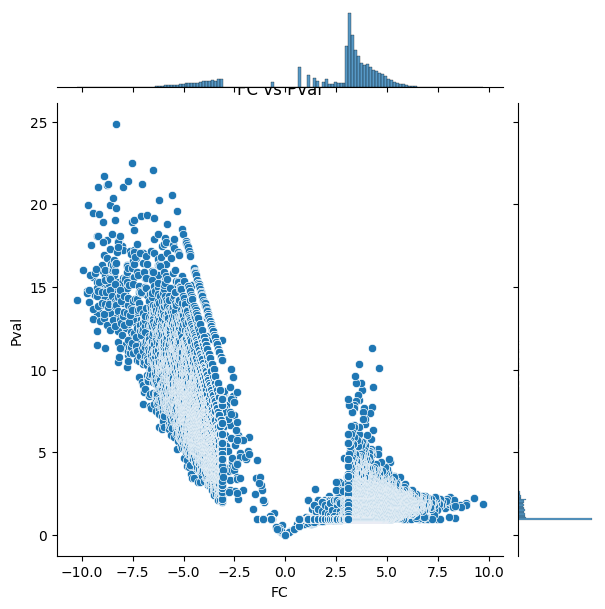

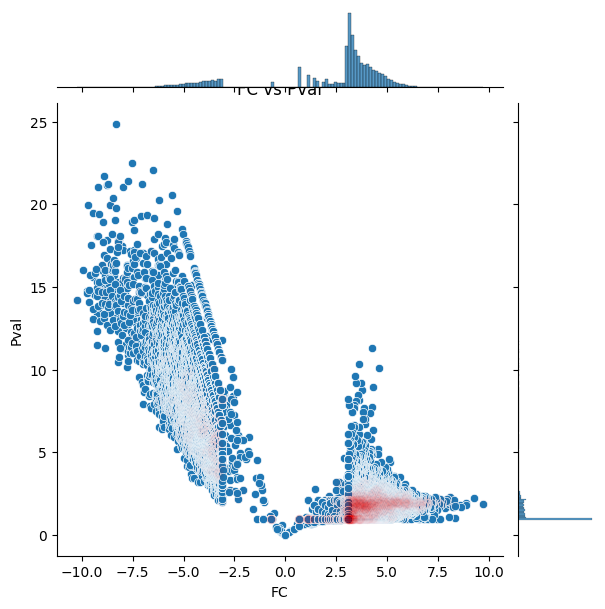

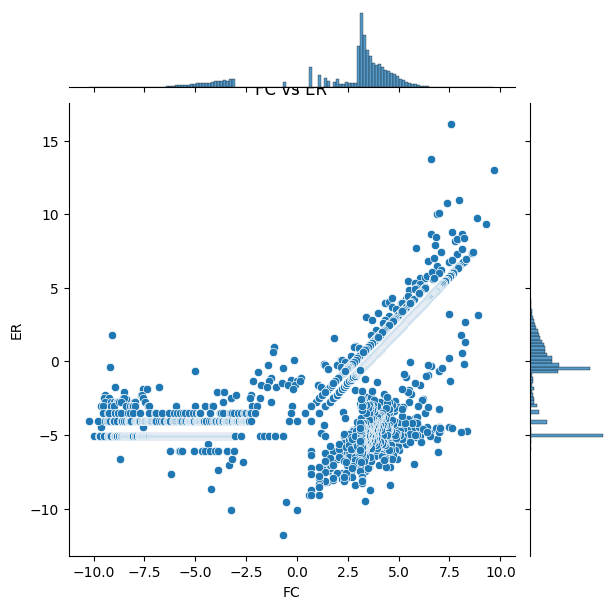

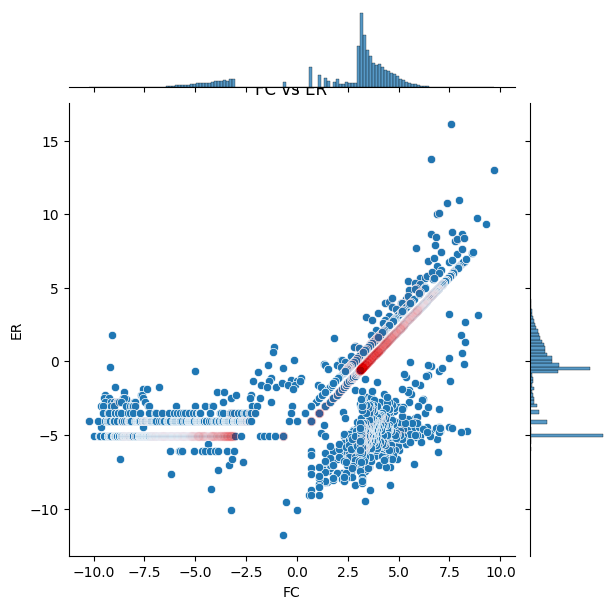

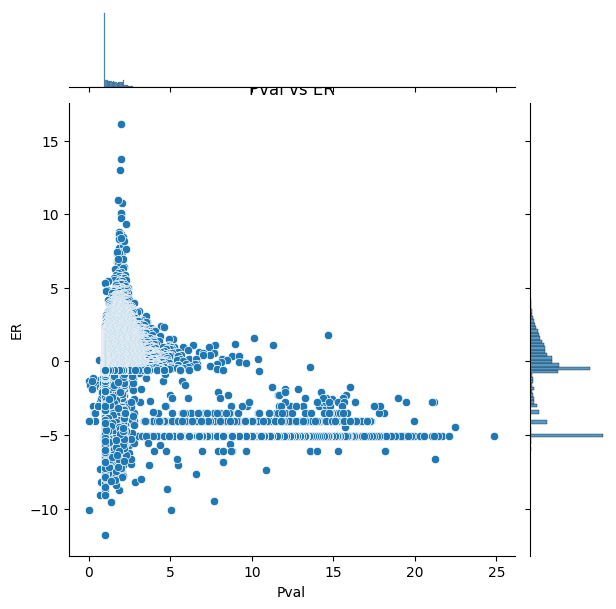

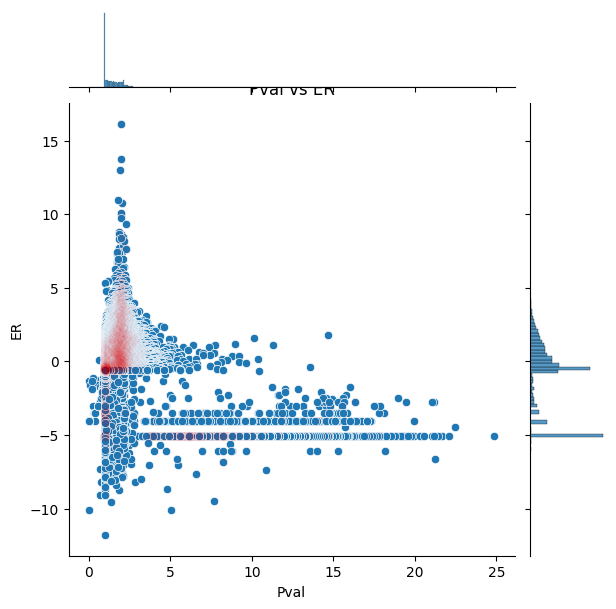

In [13]:
hypothetical_best_mdm2_ordering = np.array([ 1.0 if seq_contains_mdm2_motif(pep) else 0.0 for pep in peptides])

plot_relations(x_idx=1, y_idx=0, datapoints=y_raw, ordering=None, kind='scatter')
plot_relations(x_idx=1, y_idx=0, datapoints=y_raw, ordering=hypothetical_best_mdm2_ordering, kind='scatter')

plot_relations(x_idx=1, y_idx=2, datapoints=y_raw, ordering=None, kind='scatter')
plot_relations(x_idx=1, y_idx=2, datapoints=y_raw, ordering=hypothetical_best_mdm2_ordering, kind='scatter')

plot_relations(x_idx=0, y_idx=2, datapoints=y_raw, ordering=None, kind='scatter')
plot_relations(x_idx=0, y_idx=2, datapoints=y_raw, ordering=hypothetical_best_mdm2_ordering, kind='scatter')